In [2]:
# ===============================
# Step 0 - Setup & Imports
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_predict,
    RandomizedSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
import joblib   # to save model

RND = 42
np.random.seed(RND)
sns.set(style="whitegrid")


In [3]:
# ===============================
# Step 1 - Load Data
# ===============================
records = pd.read_excel("Students_record.xlsx")
marks   = pd.read_excel("Students_marks_data.xlsx")

print("records:", records.shape)
print("marks:", marks.shape)
display(records.head())
display(marks.head())


records: (63, 6)
marks: (630, 7)


,Roll No,Name,PRN/Reg. No,Result,Sem I SGPA,Sem II SGPA
0,14001,ADHAV SUSHANT KHANDERAO CHHAYA,2023016401107067,Passes,9.09,8.91
1,14002,PAWAR PRASAD PANDHARINATH POOJA,2023016401104371,Passes,8.00,8.27
2,14003,MANE TEJASWI HARSHAD JYOTI,2023016401109244,Passes,8.73,8.73
3,14005,GUPTA KUNAL RAMATIRATH SURYAKALA,2023016401104227,Passes,8.82,9.00
4,14006,DUBEY KOMAL MITHLESH SARITA,2023016401060733,Passes,8.55,8.55


,Roll No,Course Code,Course Title,Internal Marks Obtained,Semester End Marks Obtained,Total Marks Obtained,Grade
0,14001,RJMAJDSAI121,DATABASE MANAGEMENT SYSTEM,17,12,29,B+
1,14001,RJMAJDSAIP121,PRACTICAL OF RJMAJDSAIP121 AND RJMAJDSAP122,NaN,48,48,O
2,14001,RJMAJDSAI122,PROBABILITY DISTRIBUTION,15,27,42,O
3,14001,RJMINDSAI121,R PROGRAMMING,17,20,37,A+
4,14001,RJOECDSAI121,BUSINESS ETHICS,20,69,89,O


In [4]:
# ===============================
# Step 2 - Cleaning
# ===============================
marks["Roll No"] = marks["Roll No"].fillna(method="ffill")
marks = marks[marks["Roll No"].notna()]
marks["Roll No"] = marks["Roll No"].astype(int).astype(str)

records["Roll No"] = records["Roll No"].astype(str)

# Convert marks to numeric
for col in ["Internal Marks Obtained", "Semester End Marks Obtained", "Total Marks Obtained"]:
    if col in marks.columns:
        marks[col] = pd.to_numeric(marks[col], errors="coerce")

print("Missing values in marks:\n", marks.isnull().sum())


Missing values in marks:
 Roll No                          0
Course Code                      0
Course Title                     0
Internal Marks Obtained        130
Semester End Marks Obtained      7
Total Marks Obtained             0
Grade                            0
dtype: int64


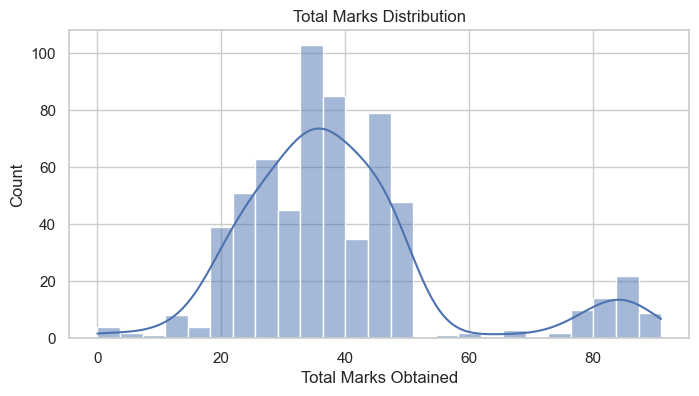

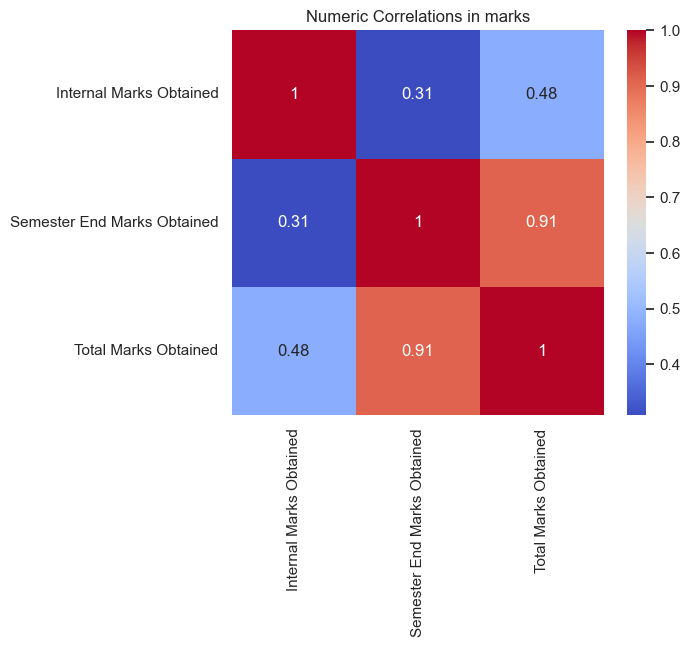

In [5]:
# ===============================
# Step 3 - EDA
# ===============================
if "Total Marks Obtained" in marks.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(marks["Total Marks Obtained"].dropna(), bins=25, kde=True)
    plt.title("Total Marks Distribution")
    plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(marks.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Numeric Correlations in marks")
plt.show()


In [6]:
# ===============================
# Step 4 - Feature Engineering
# ===============================
agg = marks.groupby("Roll No").agg({
    "Internal Marks Obtained": "mean",
    "Semester End Marks Obtained": "mean",
    "Total Marks Obtained": "mean"
}).reset_index()

agg["Num_Subjects"] = marks.groupby("Roll No").size().values
agg["Failed_Subjects"] = marks.groupby("Roll No")["Total Marks Obtained"].apply(lambda x: (x < 20).sum()).values
agg["Min_Marks"] = marks.groupby("Roll No")["Total Marks Obtained"].min().values
agg["Marks_Var"] = marks.groupby("Roll No")["Total Marks Obtained"].var().fillna(0).values

# Subject pivot
subj_pivot = marks.pivot_table(index="Roll No", columns="Course Title",
                               values="Total Marks Obtained", aggfunc='mean')
subj_pivot.columns = [f"subj_{c}" for c in subj_pivot.columns]
agg = agg.merge(subj_pivot.reset_index(), on="Roll No", how="left")

# Merge
data = records.merge(agg, on="Roll No", how="left")


In [7]:
# ===============================
# Step 5 - Label
# ===============================
def is_atkt(x):
    if pd.isna(x): return 0
    s = str(x).upper()
    return 1 if ("ATKT" in s or "FAIL" in s or "UNSUCCESS" in s) else 0

data["is_ATKT"] = data["Result"].apply(is_atkt)
print("KT distribution:\n", data["is_ATKT"].value_counts())


KT distribution:
 is_ATKT
0    53
1    10
Name: count, dtype: int64


In [8]:
# ===============================
# Step 6 - Features & Target
# ===============================
features = [
    "Internal Marks Obtained",
    "Semester End Marks Obtained",
    "Total Marks Obtained",
    "Num_Subjects",
    "Failed_Subjects",
    "Min_Marks",
    "Marks_Var"
]
features = [f for f in features if f in data.columns]

X = data[features].fillna(0)
y = data["is_ATKT"].fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)


In [9]:
# ===============================
# Step 7 - Apply SMOTE
# ===============================
sm = SMOTE(random_state=RND)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())


Before SMOTE: {0: 42, 1: 8}
After SMOTE: {1: 42, 0: 42}


Base RF Accuracy: 0.8461538461538461
Base RF F1: 0.6666666666666666
              precision    recall  f1-score   support

        Pass       1.00      0.82      0.90        11
          KT       0.50      1.00      0.67         2

    accuracy                           0.85        13
   macro avg       0.75      0.91      0.78        13
weighted avg       0.92      0.85      0.86        13

Confusion matrix:
 [[9 2]
 [0 2]]


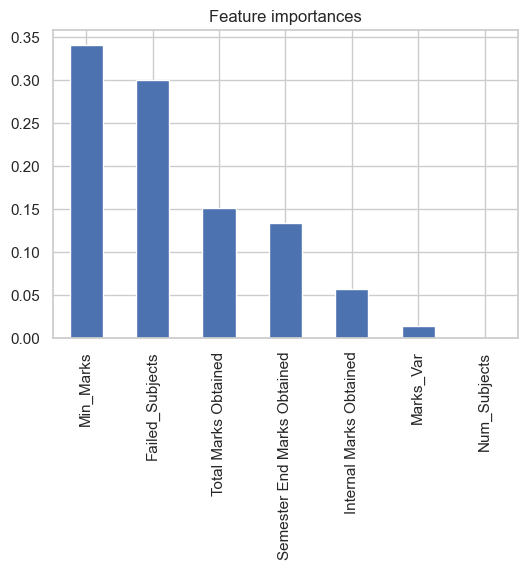

In [10]:
# ===============================
# Step 8 - Base Model
# ===============================
rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=RND)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)

base_accuracy = accuracy_score(y_test, y_pred)
base_f1 = f1_score(y_test, y_pred)

print("Base RF Accuracy:", base_accuracy)
print("Base RF F1:", base_f1)
print(classification_report(y_test, y_pred, target_names=["Pass","KT"]))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(6,4))
importances.plot(kind='bar')
plt.title("Feature importances")
plt.show()


In [11]:
# ===============================
# Step 9 - Threshold Optimization
# ===============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
oof_proba = cross_val_predict(rf, X_train_res, y_train_res, cv=skf, method='predict_proba')[:,1]

best = {"th":0.5, "f1":-1}
for t in np.linspace(0,1,101):
    preds = (oof_proba >= t).astype(int)
    f1 = f1_score(y_train_res, preds, zero_division=0)
    if f1 > best["f1"]:
        best = {"th": t, "f1": f1}
print("Best threshold:", best)

test_proba = rf.predict_proba(X_test)[:,1]
test_preds = (test_proba >= best["th"]).astype(int)
thresh_f1 = f1_score(y_test, test_preds)

print("Threshold-optimized metrics:")
print(classification_report(y_test, test_preds, target_names=["Pass","KT"]))
print("Confusion matrix:\n", confusion_matrix(y_test, test_preds))


Best threshold: {'th': 0.16, 'f1': 1.0}
Threshold-optimized metrics:
              precision    recall  f1-score   support

        Pass       1.00      0.82      0.90        11
          KT       0.50      1.00      0.67         2

    accuracy                           0.85        13
   macro avg       0.75      0.91      0.78        13
weighted avg       0.92      0.85      0.86        13

Confusion matrix:
 [[9 2]
 [0 2]]


In [12]:
# ===============================
# Step 10 - Calibration
# ===============================
cal = CalibratedClassifierCV(rf, cv=5, method='sigmoid')
cal.fit(X_train_res, y_train_res)

cal_preds = cal.predict(X_test)
calibrated_f1 = f1_score(y_test, cal_preds)

print("After calibration:")
print(classification_report(y_test, cal_preds, target_names=["Pass","KT"]))


After calibration:
              precision    recall  f1-score   support

        Pass       1.00      0.82      0.90        11
          KT       0.50      1.00      0.67         2

    accuracy                           0.85        13
   macro avg       0.75      0.91      0.78        13
weighted avg       0.92      0.85      0.86        13



In [13]:
# ===============================
# Step 11 - Hyperparameter Tuning
# ===============================
param_dist = {
    "n_estimators": [100,200,500],
    "max_depth": [5,8,12,20, None],
    "min_samples_leaf": [1,2,4,8],
    "max_features": ["sqrt","log2",0.5]
}
rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=RND),
    param_distributions=param_dist,
    n_iter=20, scoring='f1', cv=5, random_state=RND, n_jobs=-1
)
rs.fit(X_train_res, y_train_res)

print("Best params:", rs.best_params_, " Best F1 (cv):", rs.best_score_)

best_model = rs.best_estimator_
y_pred_best = best_model.predict(X_test)
tuned_f1 = f1_score(y_test, y_pred_best)

print("Final tuned RF performance:")
print(classification_report(y_test, y_pred_best, target_names=["Pass","KT"]))


Best params: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5}  Best F1 (cv): 1.0
Final tuned RF performance:
              precision    recall  f1-score   support

        Pass       1.00      0.82      0.90        11
          KT       0.50      1.00      0.67         2

    accuracy                           0.85        13
   macro avg       0.75      0.91      0.78        13
weighted avg       0.92      0.85      0.86        13



CV F1 scores: [1.  1.  1.  0.8 0.5]
Mean F1: 0.86


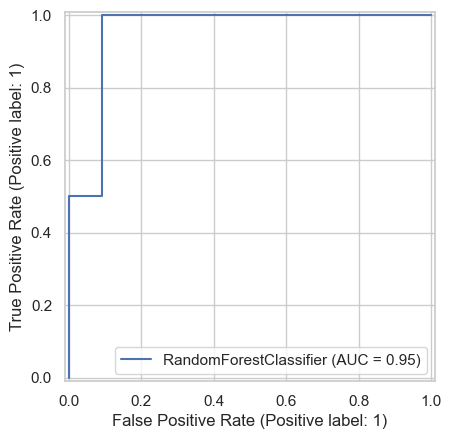

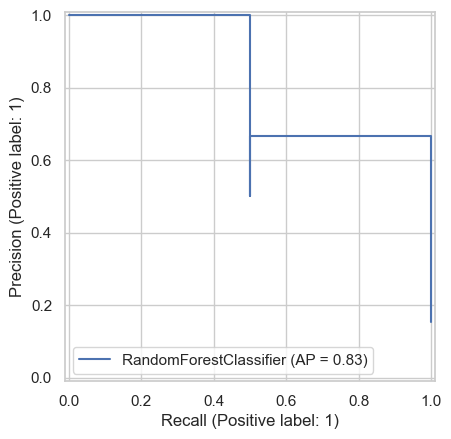

In [14]:
# ===============================
# Step 12 - Cross Validation & Plots
# ===============================
scores = cross_val_score(best_model, X, y, cv=5, scoring="f1")
print("CV F1 scores:", scores)
print("Mean F1:", scores.mean())

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.show()


In [15]:
# ===============================
# Step 13 - Final Evaluation
# ===============================
print("\n===== Final Evaluation Summary =====")
print(f"Base RF Accuracy: {base_accuracy:.2f}")
print(f"Base RF F1: {base_f1:.2f}")
print(f"Thresholded F1: {thresh_f1:.2f}")
print(f"Calibrated F1: {calibrated_f1:.2f}")
print(f"Tuned RF F1: {tuned_f1:.2f}")
print("====================================")



===== Final Evaluation Summary =====
Base RF Accuracy: 0.85
Base RF F1: 0.67
Thresholded F1: 0.67
Calibrated F1: 0.67
Tuned RF F1: 0.67


In [18]:
# ===============================
# Step X - Misclassified Students
# ===============================

# Predictions on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

# Get indices
false_pos_idx = (y_test == 0) & (y_test_pred == 1)   # Predicted KT but actually Pass
false_neg_idx = (y_test == 1) & (y_test_pred == 0)   # Predicted Pass but actually KT

# Extract student details
false_positives = data.iloc[y_test.index[false_pos_idx]][["Roll No", "Name", "Result"]]
false_negatives = data.iloc[y_test.index[false_neg_idx]][["Roll No", "Name", "Result"]]

print("\n===== Misclassified Students =====")
print("False Positives (Predicted KT but actually Pass):")
display(false_positives)

print("\nFalse Negatives (Predicted Pass but actually KT):")
display(false_negatives)



===== Misclassified Students =====
False Positives (Predicted KT but actually Pass):


,Roll No,Name,Result
51,14055,SHAIKH OOZEF ISMAIL YASMIN,Passes
61,14066,AHMAD MOHD HASIM WASEEM PARVEEN JAHA,Passes



False Negatives (Predicted Pass but actually KT):


,Roll No,Name,Result


In [20]:
# ===============================
# Step X - Save Final Model
# ===============================
import joblib

# Save the trained best model
joblib.dump(best_model, "Final_RF_SMOTE_Model.pkl")

print("✅ Model saved as Final_RF_SMOTE_Model.pkl")


✅ Model saved as Final_RF_SMOTE_Model.pkl
